In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import gym

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Lambda
from tensorflow.keras.optimizers import Adam

from collections import deque

In [2]:
class Actor(Model):
    def __init__(self, action_dim, action_bound):
        super(Actor, self).__init__()
        self.action_bound = action_bound

        self.h1 = Dense(64, activation='relu')
        self.h2 = Dense(32, activation='relu')
        self.h3 = Dense(16, activation='relu')
        self.mu  = Dense(action_dim, activation='tanh')
        self.std = Dense(action_dim, activation='softplus') # softplus function: https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html
                                                            # softplus is a smooth approximation to the ReLU function.

    def call(self, state):
        x = self.h1(state)
        x = self.h2(x)
        x = self.h3(x)
        mu  = self.mu(x)
        std = self.std(x)

        # 평균값을 [-action_bound, action_bound] 범위로 조정.
        mu = Lambda(lambda x: x * self.action_bound)(mu)

        return [mu, std]

In [3]:
class Critic(Model):
    def __init__(self):
        super(Critic, self).__init__()

        self.h1 = Dense(64, activation='relu')
        self.h2 = Dense(32, activation='relu')
        self.h3 = Dense(16, activation='relu')
        self.v  = Dense(1, activation='linear')

    def call(self, state):
        x = self.h1(state)
        x = self.h2(x)
        x = self.h3(x)
        v = self.v(x)

        return v

In [4]:
save_epi_reward = []    
save_epi_reward_buffer = deque([0.0], maxlen=100)
save_epi_reward_mean = []

In [5]:
class A2Cagent(object):
    def __init__(self, env):
        self.GAMMA = 0.95
        self.BATCH_SIZE = 32
        self.ACTOR_LEARNING_RATE = 0.0001
        self.CRITIC_LEARNING_RATE = 0.001

        self.env = env
        self.state_dim = env.observation_space.shape[0] # 상태변수 차원
        self.action_dim = env.action_space.shape[0]     # 행동 차원
        self.action_bound = env.action_space.high[0]    # 행동의 최대 크기
        self.std_bound = [1e-2, 1.0]                    # 표준편차의 최솟값과 최댓값 설정

        print("state_dim:", self.state_dim)
        print("action_dim:", self.action_dim)
        print("action_bound:", self.action_bound)
        print("std_bound:", self.std_bound)

        self.actor = Actor(self.action_dim, self.action_bound)
        self.actor.build(input_shape=(None, self.state_dim))

        self.critic = Critic()
        self.critic.build(input_shape=(None, self.state_dim))

        self.actor.summary()
        self.critic.summary()

        self.actor_opt = Adam(self.ACTOR_LEARNING_RATE)
        self.critic_opt = Adam(self.CRITIC_LEARNING_RATE)

    def log_pdf(self, mu, std, action):
        std = tf.clip_by_value(std, self.std_bound[0], self.std_bound[1])
        var = std**2
        log_policy_pdf = -0.5 * (action - mu)**2 / var - 0.5 * tf.math.log(var * 2 * np.pi)
        return tf.reduce_sum(log_policy_pdf, 1, keepdims=True)

    def get_action(self, state):
        mu_a, std_a = self.actor(state)
        mu_a = mu_a.numpy()[0]
        std_a = std_a.numpy()[0]
        std_a = np.clip(std_a, self.std_bound[0], self.std_bound[1])
        action = np.random.normal(mu_a, std_a, size=self.action_dim)

        # print("action:", action)
        return action

    def actor_learn(self, states, actions, advantages):
        with tf.GradientTape() as tape:
            mu_a, std_a = self.actor(states, training=True)
            log_policy_pdf = self.log_pdf(mu_a, std_a, actions)

            loss_policy = log_policy_pdf * advantages
            loss = tf.reduce_sum(-loss_policy)

        grads = tape.gradient(loss, self.actor.trainable_variables)
        self.actor_opt.apply_gradients(zip(grads, self.actor.trainable_variables))

    def critic_learn(self, states, td_targets):
        # td_target = reward + \gamma * v_{s_{t+1}}
        # loss = (td_target - v_{s_t})**2
        with tf.GradientTape() as tape:
            v_s_t = self.critic(states, training=True)
            loss = tf.reduce_mean(tf.square(td_targets - v_s_t))

        grads = tape.gradient(loss, self.critic.trainable_variables)
        self.critic_opt.apply_gradients(zip(grads, self.critic.trainable_variables))

    def td_target(self, rewards, next_v_values, dones):
        y_i = np.zeros(next_v_values.shape)
        for i in range(next_v_values.shape[0]):
            if dones[i]:
                y_i[i] = rewards[i]
            else:
                y_i[i] = rewards[i] + self.GAMMA * next_v_values[i]
        return y_i

    def unpack_batch(self, batch):
        unpack = batch[0]
        for idx in range(len(batch)-1):
            unpack = np.append(unpack, batch[idx+1], axis=0)

        return unpack

    def train(self):
        for ep in range(1000):
            batch_state, batch_action, batch_reward, batch_next_state, batch_done = [], [], [] ,[] ,[]
            episode_reward, done = 0, False
            state = self.env.reset()

            while not done:
                action = self.get_action(tf.convert_to_tensor([state], dtype=tf.float32))
                action = np.clip(action, -self.action_bound, self.action_bound)
                next_state, reward, done, _ = self.env.step(action)

                state = np.reshape(state, [1, self.state_dim])
                action = np.reshape(action, [1, self.action_dim])
                reward = np.reshape(reward, [1, 1])
                next_state = np.reshape(next_state, [1, self.state_dim])
                done = np.reshape(done, [1, 1])

                train_reward = (reward + 8) / 8

                batch_state.append(state)
                batch_action.append(action)
                batch_reward.append(train_reward)
                batch_next_state.append(next_state)
                batch_done.append(done)

                if len(batch_state) < self.BATCH_SIZE:
                    state = next_state[0]
                    episode_reward = episode_reward + reward[0]
                    continue    # run the while loop again

                # the program reaches to this line when len(batch_state) == self.BATCH_SIZE
                states = self.unpack_batch(batch_state)
                actions = self.unpack_batch(batch_action)
                train_rewards = self.unpack_batch(batch_reward)
                next_states = self.unpack_batch(batch_next_state)
                dones = self.unpack_batch(batch_done)

                # clear the batch
                batch_state, batch_action, batch_reward, batch_next_state, batch_done = [], [], [] ,[] ,[]

                # compute TD-targets
                next_v_values = self.critic(tf.convert_to_tensor(next_states, dtype=tf.float32))    # 32 next_v_values
                td_targets = self.td_target(train_rewards, next_v_values.numpy(), dones)    # 32 td_targets

                self.critic_learn(tf.convert_to_tensor(states, dtype=tf.float32),
                                  tf.convert_to_tensor(td_targets, dtype=tf.float32))

                v_values = self.critic(tf.convert_to_tensor(states, dtype=tf.float32))
                next_v_values = self.critic(tf.convert_to_tensor(next_states, dtype=tf.float32))
                advantages = train_rewards + self.GAMMA * next_v_values - v_values

                self.actor_learn(tf.convert_to_tensor(states, dtype=tf.float32),
                                 tf.convert_to_tensor(actions, dtype=tf.float32),
                                 tf.convert_to_tensor(advantages, dtype=tf.float32))

                state = next_state[0]
                episode_reward = episode_reward + reward[0]

            print('Episode: ', ep+1, '| Reward: ', episode_reward)

            # save reward for each episode
            save_epi_reward.append(episode_reward)

            # save averaged reward for each episode (average latest 100 rewards)
            save_epi_reward_buffer.append(episode_reward)
            save_epi_reward_mean.append(np.mean(save_epi_reward_buffer))

In [6]:
env = gym.make('Pendulum-v0')
agent = A2Cagent(env)

state_dim: 3
action_dim: 1
action_bound: 2.0
std_bound: [0.01, 1.0]
Model: "actor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  256       
                                                                 
 dense_1 (Dense)             multiple                  2080      
                                                                 
 dense_2 (Dense)             multiple                  528       
                                                                 
 dense_3 (Dense)             multiple                  17        
                                                                 
 dense_4 (Dense)             multiple                  17        
                                                                 
Total params: 2,898
Trainable params: 2,898
Non-trainable params: 0
_________________________________________________________

In [7]:
agent.train()

Episode:  1 | Reward:  [-1502.68767597]


/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:163: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


Episode:  2 | Reward:  [-1787.91115725]
Episode:  3 | Reward:  [-1507.24327223]
Episode:  4 | Reward:  [-1706.27856619]
Episode:  5 | Reward:  [-1399.86963945]
Episode:  6 | Reward:  [-1498.38100252]
Episode:  7 | Reward:  [-1806.27765955]
Episode:  8 | Reward:  [-1771.69670753]
Episode:  9 | Reward:  [-1403.21742971]
Episode:  10 | Reward:  [-1488.12769686]
Episode:  11 | Reward:  [-1851.94400739]
Episode:  12 | Reward:  [-1417.57432971]
Episode:  13 | Reward:  [-1848.11993425]
Episode:  14 | Reward:  [-1482.39041502]
Episode:  15 | Reward:  [-1484.09843345]
Episode:  16 | Reward:  [-1469.5090252]
Episode:  17 | Reward:  [-1807.55413905]
Episode:  18 | Reward:  [-1819.16646841]
Episode:  19 | Reward:  [-1481.67055597]
Episode:  20 | Reward:  [-1471.6772791]
Episode:  21 | Reward:  [-1728.12218]
Episode:  22 | Reward:  [-1845.01235036]
Episode:  23 | Reward:  [-1801.17734008]
Episode:  24 | Reward:  [-1836.23050537]
Episode:  25 | Reward:  [-1430.09965447]
Episode:  26 | Reward:  [-141

[]

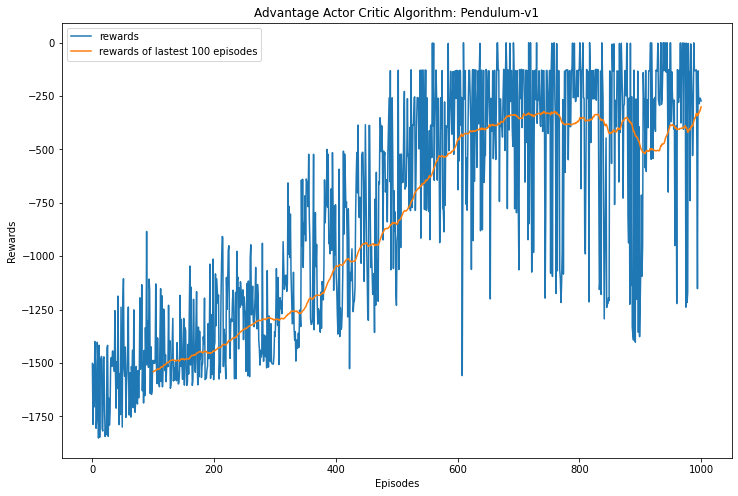

In [8]:
import pylab

fig, ax = plt.subplots(figsize=(12, 8))

x1 = np.linspace(0, 1000, 1000)
x2 = np.linspace(100, 1000, 900)

ax.plot(x1, save_epi_reward, label='rewards')
ax.plot(x2, save_epi_reward_mean[100:], label='rewards of lastest 100 episodes')

ax.set_title('Advantage Actor Critic Algorithm: Pendulum-v1')
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')
ax.legend()

ax.plot()